In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Lambda, concatenate
import os
import shutil 
import random
import numpy as np
from skimage.io import imread, imshow

from skimage.transform import resize
import matplotlib.pyplot as plt
from keras import backend as K
import cv2
seed = 42
np.random.seed = seed

IMAGE_WIDTH    = 128
IMAGE_HEIGHT   = 128
IMAGE_CHANNELS = 1


Building the model



In [ ]:
inputs = Input((IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
rescaled_input = Lambda(lambda pixel: pixel / 255)(inputs)

c1 = Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(rescaled_input)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c2)
p2 = MaxPooling2D((2, 2))(c2)
 
c3 = Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c3)
p3 = MaxPooling2D((2, 2))(c3)
 
c4 = Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c4)
p4 = MaxPooling2D(pool_size = (2, 2))(c4)
 
c5 = Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c5)

u6 = Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c6)
 
u7 = Conv2DTranspose(64, (2, 2), strides = (2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c7)
 
u8 = Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides = (2, 2), padding = 'same')(c8)
u9 = concatenate([u9, c1], axis = 3)
c9 = Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation = 'relu', kernel_initializer = 'he_normal', padding = 'same')(c9)
 
outputs = Conv2D(1, (1, 1), activation = 'sigmoid')(c9)

unet = tf.keras.Model(inputs = [inputs], outputs = [outputs])

In [ ]:
unet.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # mean_squared_error - binary_crossentropy
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
train_path = 'drive/MyDrive/image/'
!ls

drive  sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Training unet for lung segmentation


In [ ]:
def load(dir):
    root_path = train_path+dir
    X = []
    y = []
    for filename in os.listdir(root_path):
      if 'mask' not in filename:
        X.append(cv2.resize(cv2.imread(root_path+'/'+filename,0),(128,128)))
        y.append(cv2.resize(cv2.imread(root_path+'/'+filename.split('.jpg')[0]+'_mask.jpg',0),(128,128)))
    return np.array(X),np.array(y)

In [ ]:
X,y = load('sagittal')

In [ ]:
y = np.where(y!=255,1,0)

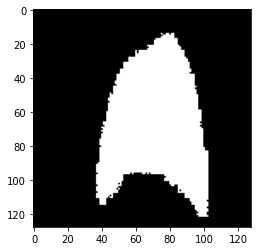

In [ ]:
plt.imshow(y[50],'gray')

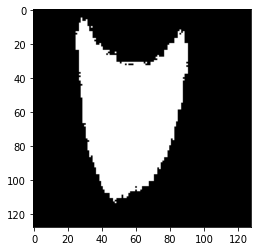

In [ ]:
plt.imshow(y180[50],'gray')

In [ ]:
X180,y180 = load('sagittal180')

In [ ]:
y180 = np.where(y180!=255,1,0)

In [ ]:
X180.shape

(64, 128, 128)

In [ ]:
X_train, Y_train = load_dataset(train_path + 'coronal/')
print(X_train.shape)
print(Y_train.shape)

Total Count: 174
(87, 128, 128, 3)
(87, 128, 128, 1)


In [ ]:
X_train_180,Y_train_180 = load_dataset(train_path + 'coronal180/')
print(X_train_180.shape)
print(Y_train_180.shape)

Total Count: 176
(88, 128, 128, 3)
(88, 128, 128, 1)


(64, 128, 128, 3)

In [ ]:
X_train = np.concatenate((X,X180),axis=0).astype(np.float32)
Y_train = np.concatenate((y,y180),axis=0).astype(np.float32)

(175, 128, 128, 3)

13539


In [ ]:
X_train = X_train.reshape(-1,128,128,1)

In [ ]:
Y_train = Y_train.reshape(-1,128,128,1)

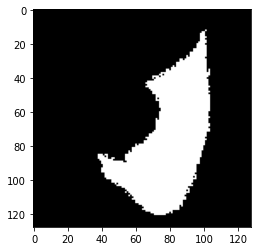

In [ ]:
plt.imshow(Y_train[0,:,:,0],'gray')

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('unet.h5', verbose = 1, save_best_only = True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                              patience=1, min_lr=0)
callbacks = [checkpointer,reduce_lr]
results = unet.fit(X_train, Y_train, validation_split = 0.1, batch_size = 16, epochs = 50, callbacks = callbacks)

Epoch 1/50
8/8 [==============================] - 3s 206ms/step - loss: 0.7606 - accuracy: 0.3950 - val_loss: 0.6223 - val_accuracy: 0.7172

Epoch 00001: val_loss improved from inf to 0.62231, saving model to unet.h5
Epoch 2/50
8/8 [==============================] - 0s 41ms/step - loss: 0.5804 - accuracy: 0.7503 - val_loss: 0.5804 - val_accuracy: 0.7177

Epoch 00002: val_loss improved from 0.62231 to 0.58043, saving model to unet.h5
Epoch 3/50
8/8 [==============================] - 0s 41ms/step - loss: 0.4930 - accuracy: 0.7524 - val_loss: 0.4215 - val_accuracy: 0.7177

Epoch 00003: val_loss improved from 0.58043 to 0.42152, saving model to unet.h5
Epoch 4/50
8/8 [==============================] - 0s 41ms/step - loss: 0.4166 - accuracy: 0.7562 - val_loss: 0.4351 - val_accuracy: 0.7177

Epoch 00004: val_loss did not improve from 0.42152
Epoch 5/50
8/8 [==============================] - 0s 42ms/step - loss: 0.3623 - accuracy: 0.7583 - val_loss: 0.3644 - val_accuracy: 0.7177

Epoch 00005:

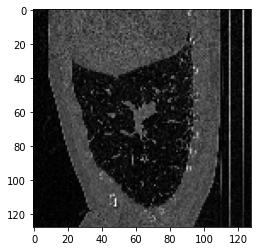

In [ ]:
train_image_20 = X_train[40,:,:,0]
plt.imshow(train_image_20, cmap = 'gray')

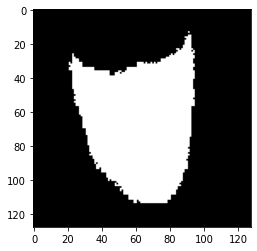

In [ ]:
train_mask_20 = Y_train[40]
plt.imshow(np.squeeze(train_mask_20), cmap = 'gray')

4/4 [==============================] - 0s 35ms/step


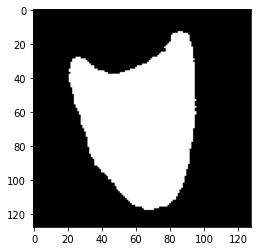

In [ ]:
preds_train = unet.predict(X_train, verbose = 1)
preds_train_t = (preds_train >= 0.33).astype(np.uint8)
plt.imshow(np.squeeze(preds_train_t[40]), cmap = 'gray')

In [ ]:
unet.save('/content/drive/MyDrive/image/unet_coronal_final.h5')

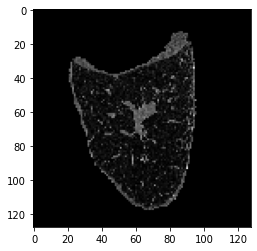

In [ ]:
plt.imshow(np.squeeze(preds_train_t[40])* train_image_20, cmap = 'gray')

In [ ]:
unet.load_weights('/content/drive/MyDrive/w/unet_coronal_final.h5')

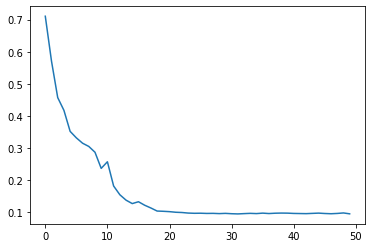

In [ ]:
plt.plot(results.history['loss'])

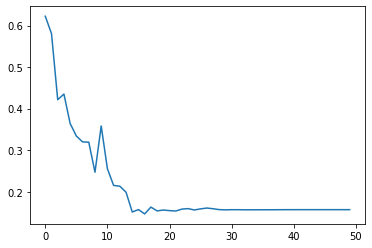

In [ ]:
plt.plot(results.history['val_loss'])

In [ ]:
unet.load_weights('/content/drive/MyDrive/w/unet_sagittal_final.h5')

In [ ]:
!mkdir /content/drive/MyDrive/mask_sagittal

In [ ]:
!rm -r /content/drive/MyDrive/mask_sagittal

In [ ]:
for patient in os.listdir('/content/drive/MyDrive/sagittal'):
    os.mkdir(f'/content/drive/MyDrive/mask_sagittal/{patient}')
    for slices in os.listdir(f'/content/drive/MyDrive/sagittal/{patient}'):
        image = cv2.imread(f'/content/drive/MyDrive/sagittal/{patient}/{slices}',0)
        image = np.array(image).reshape(1,128,128,1)
        preds_train = unet.predict(image, verbose = 1)
        preds_train_t = (preds_train >= 0.33)
        plt.imsave(f'/content/drive/MyDrive/mask_sagittal/{patient}/{slices}',np.squeeze(preds_train_t*image), cmap = 'gray')

1/1 [==============================] - 0s 14ms/step


176
